## importing libraries

In [1]:
import pandas as pd 
import cv2 
import base64
import IPython
import json
import numpy as np
import os
import random
import requests
from io import BytesIO
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
import matplotlib.pyplot as plt

In [3]:
# import data to prepare 
import os
path = "trees.v19i.coco-segmentation/"
train_images = os.path.join(path , "train/images")
validation_images  =os.path.join(path , "valid/images")

In [3]:
print(train_images)

trees.v19i.coco-segmentation/train/images


## utils functions 

In [5]:
import csv 
import matplotlib.patches as patches 
# define a class that reads the dataset entirely and extract the images masks  
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                        'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                        'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                        'magenta', 'sienna', 'maroon']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        #self.process_info()
        #self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()

    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')
        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, show_labels=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)
            
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        img_str = "data:image/png;base64, " + base64.b64encode(buffered.getvalue()).decode()
        
        # Calculate the size and adjusted display size
        max_width = 2000
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        labels = {}
        print('  segmentations ({}):'.format(len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1 , 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})
                            
                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1 # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(full_lines_to_insert * adjusted_ratio)
                                rle_list.append({'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})
                                
                            # Insert bottom line
                            rle_list.append({'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list  
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(str(segmentation_points).lstrip('[').rstrip(']'))

            polygons[segm['id']] = polygons_list

            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'
            
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
            
            labels[segm['id']] = (self.categories[segm['category_id']]['name'], (bbox_points[0], bbox_points[1] - 4))
            
            # Print details
            print('    {}:{}:{}'.format(segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))

        # Draw segmentation polygons on image
        html = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(img_str, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(adjusted_width, adjusted_height)
        
        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(points, fill_color, stroke_color)
        
        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(x, y, w, h, fill_color, stroke_color)
            
        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(points, fill_color, stroke_color)
                
        if show_labels:
            for seg_id, label in labels.items():
                color = poly_colors[seg_id]
                html += '<text x="{}" y="{}" style="fill:{}; font-size: 12pt;">{}</text>'.format(label[1][0], label[1][1], color, label[0])
                
        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html
       
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id} # Create a new set with the category id
            else:
                self.super_categories[super_category] |= {cat_id} # Add category id to the set
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)


    def display_image_with_mask(self, image_id):
        # Charger les informations de l'image
        if image_id not in self.images:
            print(f"Image ID {image_id} not found in dataset.")
            return
        
        image_info = self.images[image_id]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = PILImage.open(image_path)
        image_width, image_height = image.size
        
        # Créer un masque vide
        full_mask = np.zeros((image_height, image_width), dtype=np.uint8)
        
        # Ajouter chaque segmentation au masque
        if image_id in self.segmentations:
            for segm in self.segmentations[image_id]:
                mask = PILImage.new('L', (image_width, image_height), 0)
                draw = PILImageDraw.Draw(mask)
                
                if segm['iscrowd'] == 0:
                    for polygon in segm['segmentation']:
                        # Convertir les points du polygone en tuples
                        polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                        draw.polygon(polygon, outline=1, fill=1)
                else:
                    # Décoder RLE pour obtenir un masque
                    mask_array = self.decode_rle(segm['segmentation'])
                    mask = Image.fromarray(mask_array)

                # Ajouter au masque complet
                full_mask = np.maximum(full_mask, np.array(mask))
        
        # Afficher l'image et le masque côte à côte
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(image)
        axes[0].axis("off")
        axes[0].set_title("Original Image")
        
        axes[1].imshow(full_mask, cmap="gray")
        axes[1].axis("off")
        axes[1].set_title("Mask")
        
        plt.tight_layout()
        plt.show()
    def export_bounding_boxes(self, output_csv_path):

        with open(output_csv_path, mode='w', newline='') as csvfile:
            fieldnames = ['image_id', 'image_name', 'bbox_id', 'bbox']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            writer.writeheader()  # Écrire les en-têtes du fichier CSV

            # Parcourir les images et leurs segmentations
            for image_id, image_info in self.images.items():
                image_name = image_info['file_name']
                
                # Vérifier s'il y a des annotations pour l'image
                if image_id in self.segmentations:
                    for segm in self.segmentations[image_id]:
                        # Extraire les informations de la boîte englobante
                        bbox = segm['bbox']
                        bbox_id = segm['id']
                        
                        # Ajouter une ligne dans le fichier CSV
                        writer.writerow({
                            'image_id': image_id,
                            'image_name': image_name,
                            'bbox_id': bbox_id,
                            'bbox': bbox
                        })
                        
                print(f"Bounding boxes for image {image_name} saved in CSV.")
        
        print(f"All bounding boxes have been exported to {output_csv_path}.")


    def export_masks(self, output_dir):
        """
        mask export and for each 
        
        Args:
            output_dir (str): Dossier où les masques seront enregistrés.
            
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        for image_id, image_info in self.images.items():
            # Charger les dimensions de l'image
            image_path = os.path.join(self.image_dir, image_info['file_name'])
            image_name = os.path.basename(image_info['file_name'])
            image_width, image_height = image_info['width'], image_info['height']
            
            # Créer un masque vide
            full_mask = np.zeros((image_height, image_width), dtype=np.uint8)
            
            # Ajouter les segmentations au masque
            if image_id in self.segmentations:
                for segm in self.segmentations[image_id]:
                    mask = PILImage.new('L', (image_width, image_height), 0)
                    draw = PILImageDraw.Draw(mask)
                    
                    if segm['iscrowd'] == 0:
                        for polygon in segm['segmentation']:
                            # Convertir les points du polygone en tuples
                            polygon = [(polygon[i], polygon[i + 1]) for i in range(0, len(polygon), 2)]
                            draw.polygon(polygon, outline=1, fill=1)
                    else:
                        # Décoder RLE pour obtenir un masque
                        mask_array = self.decode_rle(segm['segmentation'])
                        mask = Image.fromarray(mask_array)
                    
                    # Ajouter au masque complet
                    full_mask = np.maximum(full_mask, np.array(mask))
            
            # Enregistrer le masque
            mask_image = PILImage.fromarray((full_mask * 255).astype(np.uint8))  # Convertir en image binaire
            mask_output_path = os.path.join(output_dir, os.path.splitext(image_name)[0] + "_mask.png")
            mask_image.save(mask_output_path)
            print(f"Mask saved: {mask_output_path}")

    def decode_rle(self, rle):
        """Décoder un RLE en masque binaire."""
        counts = rle['counts']
        height, width = rle['size']
        mask = np.zeros(height * width, dtype=np.uint8)
        
        current_index = 0
        for i, count in enumerate(counts):
            if i % 2 == 0:
                current_index += count
            else:
                mask[current_index:current_index + count] = 1
                current_index += count
    
        return mask.reshape((height, width), order='F')

    def display_image_with_bboxes(self, image_id):
        """
        Affiche l'image avec ses boîtes englobantes.

        Args:
            image_id (int): ID de l'image à afficher.
        """
        # Charger les informations de l'image
        if image_id not in self.images:
            print(f"Image ID {image_id} not found.")
            return
        
        image_info = self.images[image_id]
        image_name = image_info['file_name']
        image_path = os.path.join(self.image_dir, image_name)
        
        # Charger l'image
        img = PILImage.open(image_path)
        
        # Créer la figure et les axes
        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(img)
        
        # Vérifier si des annotations existent pour l'image
        if image_id in self.segmentations:
            for segm in self.segmentations[image_id]:
                # Extraire la boîte englobante
                bbox = segm['bbox']
                x, y, w, h = bbox
                
                # Créer un rectangle représentant la boîte englobante
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                
                # Ajouter un texte avec l'ID de la boîte englobante
                ax.text(x, y - 5, f"ID: {segm['id']}", color='r', fontsize=10, ha='center')

        # Titre et affichage
        ax.set_title(f"Image: {image_name} with Bounding Boxes")
        plt.show()



In [15]:
annotation_path ="trees.v19i.coco-segmentation/train/_annotations.coco.json"
image_dir = train_images 
coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()
# coco_dataset.display_licenses()
coco_dataset.display_categories()

Categories:
  super_category: none
    id 0: oil-palm-trees-xD2I

  super_category: oil-palm-trees-xD2I
    id 1: oil-palm-trees-xD2I



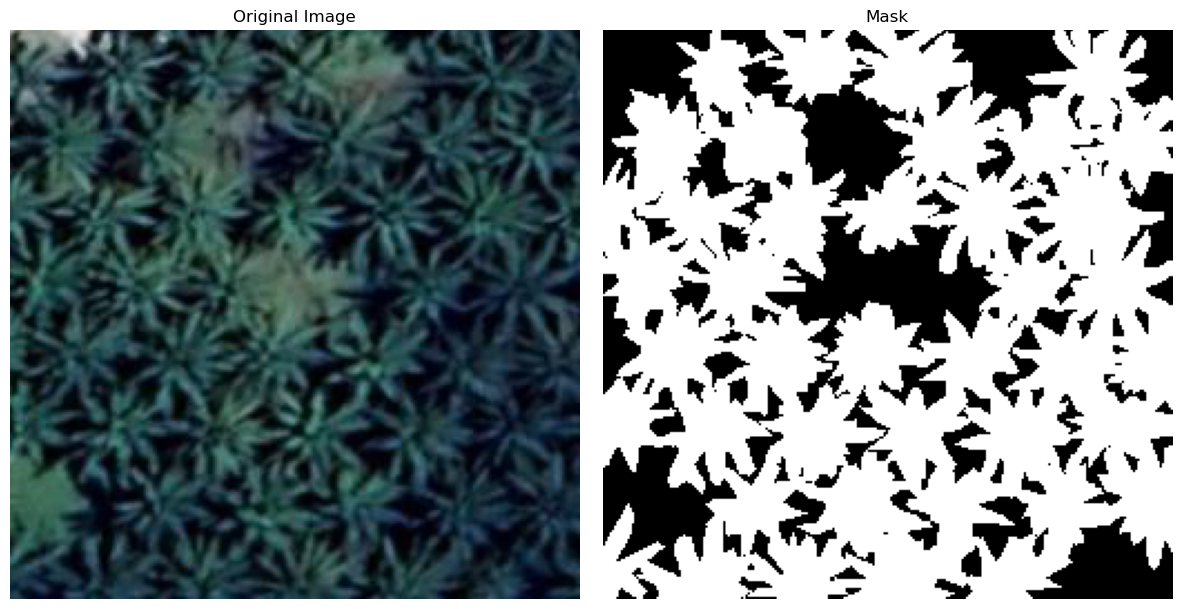

In [23]:
import matplotlib.pyplot as plt 
dataset = CocoDataset(annotation_path="trees.v19i.coco-segmentation/train/_annotations.coco.json", image_dir = train_images) 
dataset.display_image_with_mask(image_id=24)

In [67]:
#writing mask data and add a dataframe containing the mask and their corresponding image , repeat the same process for test and validation set 
dataset = CocoDataset(annotation_path="trees.v19i.coco-segmentation/train/_annotations.coco.json", image_dir=train_images)
dataset.export_masks(output_dir=os.path.join(path , "train/masks"))

Mask saved: trees.v19i.coco-segmentation/train/masks\41aa_jpg.rf.0453cb29bd262c6b46fc9c3b14e41e1c_mask.png
Mask saved: trees.v19i.coco-segmentation/train/masks\2aaa_jpg.rf.038352504528cbd6e64af432e10b5f16_mask.png
Mask saved: trees.v19i.coco-segmentation/train/masks\5aaa_jpg.rf.11b90448f1d5370ab59fa70df0557a5c_mask.png
Mask saved: trees.v19i.coco-segmentation/train/masks\13aa_jpg.rf.125cc7134f1fbffd48504a42f9243826_mask.png
Mask saved: trees.v19i.coco-segmentation/train/masks\48aaa_jpg.rf.1306bfc4fee7423e9001a0940842c958_mask.png
Mask saved: trees.v19i.coco-segmentation/train/masks\37aaa_jpg.rf.249f83b82f129c0b4efabffe388ccab8_mask.png
Mask saved: trees.v19i.coco-segmentation/train/masks\49aaa_jpg.rf.23c85916d270ee27f2c69f8a400d7472_mask.png
Mask saved: trees.v19i.coco-segmentation/train/masks\2aa_jpg.rf.2525dbf18330c07b8efaca3a4d6f60f1_mask.png
Mask saved: trees.v19i.coco-segmentation/train/masks\11aa_jpg.rf.0f198276469a24e7a29e4c0e3ca737b5_mask.png
Mask saved: trees.v19i.coco-segment

In [79]:
#  do the same to validation set 
dataset = CocoDataset(annotation_path="trees.v19i.coco-segmentation/valid/_annotations.coco.json", image_dir=validation_images)
dataset.export_masks(output_dir=os.path.join(path , "valid/masks"))

Mask saved: trees.v19i.coco-segmentation/valid/masks\21aa_jpg.rf.0f3755367f38265fc3cfce411feb30d6_mask.png
Mask saved: trees.v19i.coco-segmentation/valid/masks\20aa_jpg.rf.1e35120f30a6d95f548ed592aafa0f7f_mask.png
Mask saved: trees.v19i.coco-segmentation/valid/masks\16aaa_jpg.rf.129ef094eb69ddaddcdcc982d1dda814_mask.png
Mask saved: trees.v19i.coco-segmentation/valid/masks\1-kiri-bawah_png_jpg.rf.12c89e8057a8a2c49ee8ce315fcd8bc3_mask.png
Mask saved: trees.v19i.coco-segmentation/valid/masks\44000_4000_83_803_jpg.rf.495ebdc4a5bb62c14767966459e34e15_mask.png
Mask saved: trees.v19i.coco-segmentation/valid/masks\2-kiri-atas_png_jpg.rf.39a2b61b4e637b64d833ed7567642d07_mask.png
Mask saved: trees.v19i.coco-segmentation/valid/masks\4aaa_jpg.rf.3b53c9af2f9344862ca481a519fe805b_mask.png
Mask saved: trees.v19i.coco-segmentation/valid/masks\19aaa_jpg.rf.4bc05f7e87079b0e1338745fbc4a1a7e_mask.png
Mask saved: trees.v19i.coco-segmentation/valid/masks\14aa_jpg.rf.3aa16679e0e2868716b4d30884a541d0_mask.png

In [ ]:
for file_name in os.listdir(os.path.join(path , "train/images")):
    if file_name.endswith(".jpg"):
        print(os.listdir(os.path.join(path , "train/images")))

In [198]:
# create csv files for training and for validation the csv file contain bothe image path and mask path 
import os
import pandas as pd

# List to store file names
images_names = []

# Iterate through all files in the folder
for file_name in os.listdir(os.path.join(path , "train/images") ):
    if file_name.endswith(".jpg"):
        images_names.append(os.path.join(path , "train/images/{}").format(file_name))
# iterate through the masks 
masks_name = [] 
for file_name in os.listdir(os.path.join(path , "train/masks") ):
    if file_name.endswith(".png"):  # Ensure it's a file
        masks_name.append(os.path.join(path , "train/masks/{}").format(file_name))
# Create a DataFrame
df = pd.DataFrame({'image' : images_names , 'mask' :masks_name}  , columns=["image" , "mask"])
df.to_csv("training_images_annotation.csv")


In [188]:
print(df.image[0])

trees.v19i.coco-segmentation/train/images/10aaa_jpg.rf.6add19725c40d7627f4a30d7ec513f21.jpg


In [200]:
# create csv files for training and for validation the csv file contain bothe image path and mask path 
import os
import pandas as pd

# List to store file names
images_names = []

# Iterate through all files in the folder
for file_name in os.listdir(os.path.join(path , "valid/images")):
    if file_name.endswith(".jpg"):
        images_names.append(os.path.join(path , "valid/images/{}".format(file_name) ))
# iterate through the masks 
masks_name = [] 
for file_name in os.listdir(os.path.join(path , "valid/masks")):
    if file_name.endswith(".png"):  # Ensure it's a file
        masks_name.append(os.path.join(path , "valid/masks/{}").format(file_name) )
# Create a DataFrame
df = pd.DataFrame({'image' : images_names , 'mask' :masks_name}  , columns=["image" , "mask"])
df.to_csv("validtion_images_annotation.csv")


In [27]:
# read the csv files a
train_df = pd.read_csv("training_images_annotation.csv")
valid_df = pd.read_csv("validtion_images_annotation.csv")

In [29]:
valid_df

,Unnamed: 0,image,mask
0,0,trees.v19i.coco-segmentation/valid/images/1-ka...,trees.v19i.coco-segmentation/valid/masks/1-kan...
1,1,trees.v19i.coco-segmentation/valid/images/1-ki...,trees.v19i.coco-segmentation/valid/masks/1-kir...
2,2,trees.v19i.coco-segmentation/valid/images/11aa...,trees.v19i.coco-segmentation/valid/masks/11aa_...
3,3,trees.v19i.coco-segmentation/valid/images/12aa...,trees.v19i.coco-segmentation/valid/masks/12aa_...
4,4,trees.v19i.coco-segmentation/valid/images/14aa...,trees.v19i.coco-segmentation/valid/masks/14aa_...
5,5,trees.v19i.coco-segmentation/valid/images/14aa...,trees.v19i.coco-segmentation/valid/masks/14aa_...
6,6,trees.v19i.coco-segmentation/valid/images/16aa...,trees.v19i.coco-segmentation/valid/masks/16aaa...
7,7,trees.v19i.coco-segmentation/valid/images/16aa...,trees.v19i.coco-segmentation/valid/masks/16aaa...
8,8,trees.v19i.coco-segmentation/valid/images/17aa...,trees.v19i.coco-segmentation/valid/masks/17aa_...
9,9,trees.v19i.coco-segmentation/valid/images/17aa...,trees.v19i.coco-segmentation/valid/masks/17aa_...


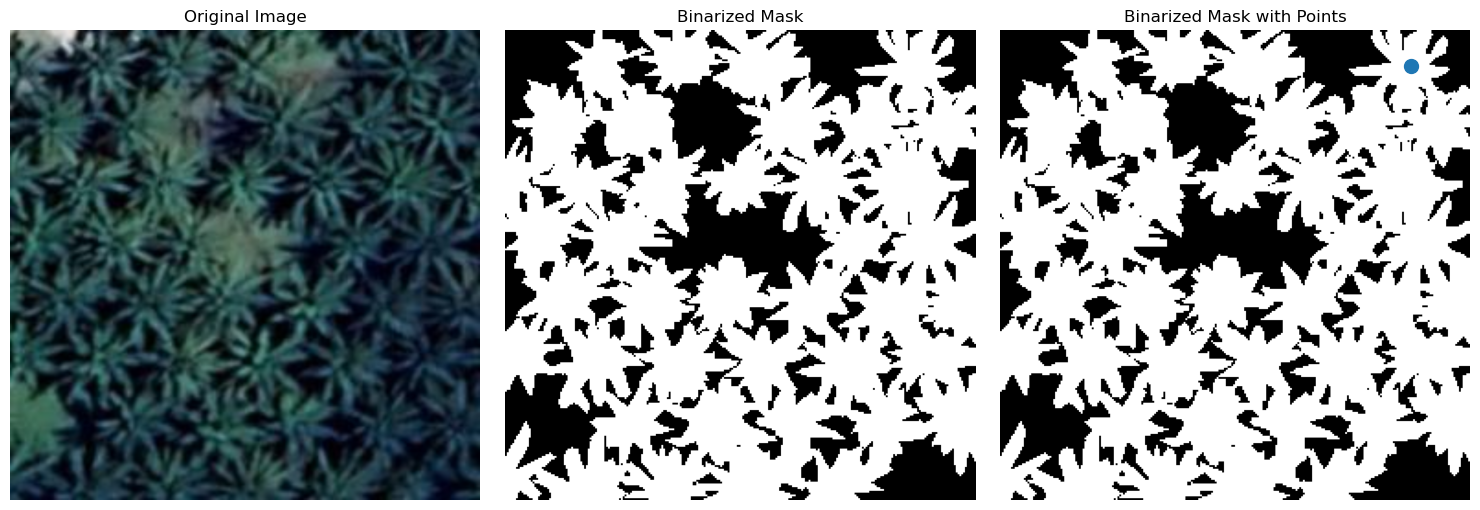

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data.iloc[np.random.randint(len(data))]

    # Get full paths for image and annotation
    Img = cv2.imread(ent["image"])[..., ::-1]  # Read image and convert from BGR to RGB
    ann_map = cv2.imread(ent["mask"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    # Check if either the image or annotation could not be read
    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Rescale the image and annotation to fit within 1024x1024
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Calculate scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize binary mask and list of points
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)  
    points = []

    # Process each unique label in the annotation map (except the background, index 0)
    inds = np.unique(ann_map)[1:]  # Skip the background label
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Binary mask for the current label
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid selecting boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])  # Append x, y (note reverse order)

    # Convert points to a NumPy array
    points = np.array(points)

    # Visualization (if requested)
    if visualize_data:
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Binary mask
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Binary mask with points
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')

        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Expand binary mask dimensions for consistency
    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Shape becomes (H, W, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))  # Convert to (1, H, W)
    points = np.expand_dims(points, axis=1)  # Shape becomes (num_points, 1, 2)

    # Return the processed data
    return Img, binary_mask, points, len(inds)

# Example usage
# Ensure df is a DataFrame or list-like object containing image paths and annotation paths
Img1, masks1, points1, num_masks = read_batch(train_df, visualize_data=True)

In [ ]:
# exporting of masks for both training and validation data 
dataset = CocoDataset(annotation_path="trees.v19i.coco-segmentation/train/_annotations.coco.json", image_dir=train_images)
dataset.export_bounding_boxes("trees.v19i.coco-segmentation/train/" + "train_bbox.csv")

In [ ]:
dataset = CocoDataset(annotation_path="trees.v19i.coco-segmentation/train/_annotations.coco.json", image_dir=validation_images)
dataset.export_bounding_boxes("trees.v19i.coco-segmentation/valid/" + "valid_bbox.csv")

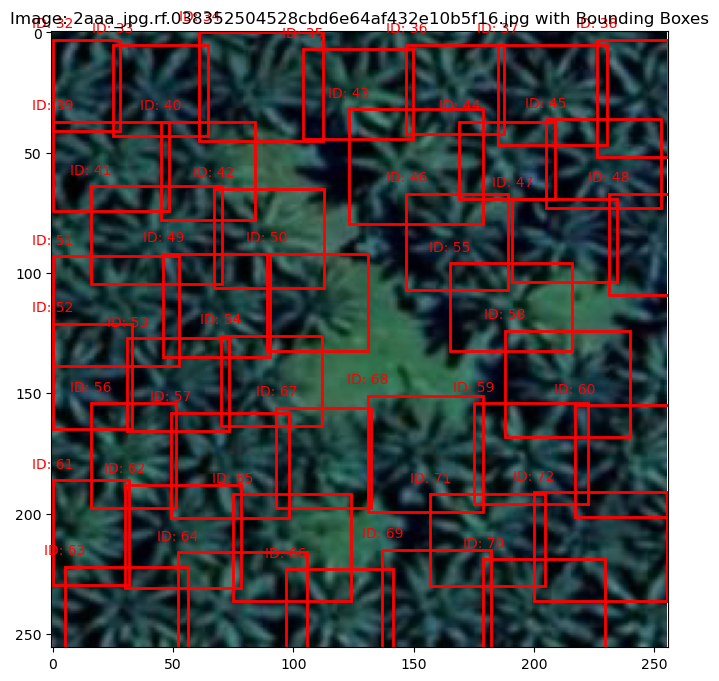

In [21]:
image_id = 1  # Remplacez par l'ID de l'image que vous voulez afficher
dataset.display_image_with_bboxes(image_id)